
## Capstone Project: Final Report
### Problem: Creating ML models to detect credit card Fraud transactions

**Introduction** 

In this capstone project, we begin by understanding the business problem at hand. This is followed by exploratory data analysis, including data cleaning and preprocessing—such as handling categorical variables. We then build and train models suitable for binary classification tasks, and present visualizations to highlight key findings. In the project, we communicate our results to both technical and non-technical audiences, while highlighting the insights back to the overall purpose of the study.

In [ ]:
#import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

### The Dataset

We use the credit fraud dataset to predict fraud or legitimate transactions -- 1 or 0.  The data is loaded is the original size of 480 MB with 6362620 records and 11 fields. We later, sample only 5000 records for train and fit our models below.

In [106]:
# Load dataset (creditFraud)
df = pd.read_csv('creditfraudPaySim.csv')

In [89]:
# Return shape (#records, #fields) of the dataset
# Return class distribution of the target variable (isFraud")
print(f"Dataset shape: {df.shape}\nClass distribution:\n{df['isFraud'].value_counts(normalize=True)}")

Dataset shape: (6362620, 11)
Class distribution:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [90]:
# Explore Fraud Vs non- Fraud transactions in the entire dataset
print(f"Count of fraudulent transactions: {len(df[df['isFraud'] == 1])}")
print(f"Count of non-fraudulent transactions: {len(df[df['isFraud'] == 0])}")

Count of fraudulent transactions: 8213
Count of non-fraudulent transactions: 6354407


### Data Visualization

We use countplots and scatterplots to visually inspect the distribution of the entire dataset.

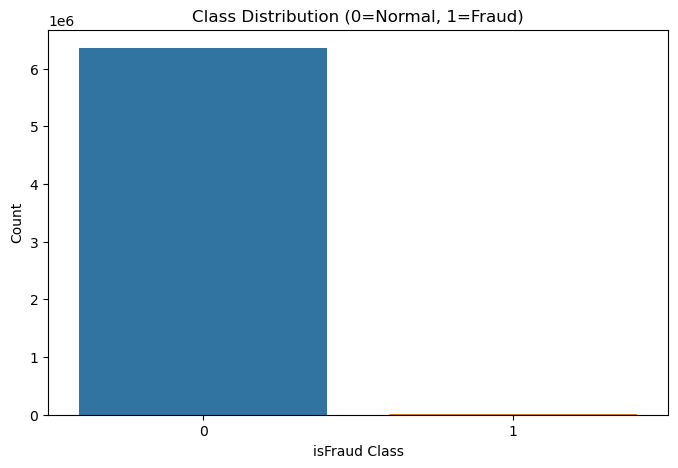

In [91]:
# Show plot of Fraud Vs non- Fraud transactions in the entire dataset
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution (0=Normal, 1=Fraud)')
plt.xlabel('isFraud Class')
plt.ylabel('Count')
plt.show()

In [92]:
# Here, we aim to determine how many transactions were flagged as fraudulent but are not actually labeled as fraudulent.
normal = df[df['isFraud']==0]['amount'] #normal means not fraudulent
fraud = df[df['isFlaggedFraud']==1]['amount'] #this means the transaction was flagged as fraudulent, 
                                              #but it's uncertain whether it is actually fraud.

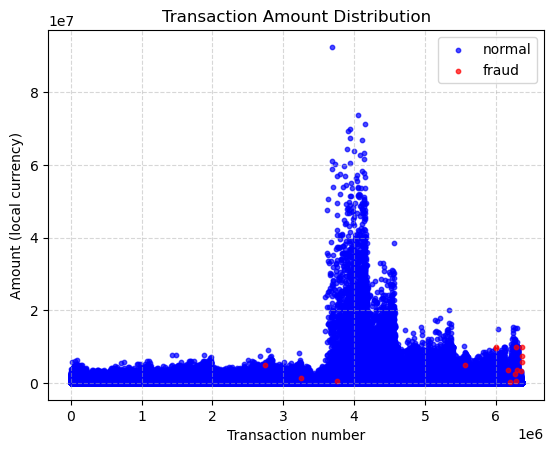

In [93]:
# Scatter Plot: Transaction Amount Distribution
plt.scatter(normal.index, normal, alpha=0.7, c='blue', s=10, label='normal')
plt.scatter(fraud.index, fraud, alpha=0.7, c='red', s=10, label='fraud')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction number')
plt.ylabel('Amount (local currency)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### Further Data Exploration 

We focus on interesting questions, such as determining how many transactions were both flagged and labeled as fraudulent, and how many were flagged as fraud but not actually labeled as such.

In [94]:
# Here, we aim to determine how many transactions were flagged as fraudulent and are actually labeled as fraudulent.
normal = df[df['isFraud']==1]['amount'] #normal means not fraudulent
flaggedFraud = df[df['isFlaggedFraud']==1]['amount'] #this means the transaction was flagged as fraudulent, but it's uncertain whether it is actually fraud.

In [95]:
# We intend to count how many transaction were flagged as fraud but weren't actually labelled as fraud.
count = len(df[(df['isFraud'] == 0) & (df['isFlaggedFraud'] == 1)])
print(f"Number of transactions flagged as fraudulent but later identified as not fraud: {count}")

Number of transactions flagged as fraudulent but later identified as not fraud: 0


In [96]:
# We intend to count how many transaction were flagged as fraud and were actually labelled as fraud.

count = len(df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)])
print(f"Number of transactions flagged as fraudulent but later identified as fraud: {count}")

Number of transactions flagged as fraudulent but later identified as fraud: 16


In [97]:
# Recall: tatal number of frauds in the entire dataset
count = len(df[df['isFraud'] == 1])
print(f"Total number of fraud transactions: {count}")

Total number of fraud transactions: 8213


### Preprocessing data
#### Column transformer for categorical encoding

Use `ColumnTransformer` to define a preprocessing pipeline. Apply OneHotEncoder to the categorical features to efficiently encode binary categorical data. For all remaining numerical features, apply StandardScaler() to standardize them.


In [98]:
# Reduce our sample to 50000 from 6362620 record to fir simple models and enable training
df_sample = df[:50000]

# select target and features
X = df_sample.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1) # drop isFraud, nameOrg, and nameDest from independent features
y = df_sample['isFraud'] # select isFraud as target feature 

In [99]:
# Define categorical and numeric features
categorical_features = ['type']
numeric_features = X.drop(columns=categorical_features + ['isFlaggedFraud']).columns.tolist()

In [100]:
# We use ColumnTransformer for handle categorical and numerial features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)




#### Create train/test split


Use the `train_test_split` function to create a train test split on `X` and `y` with 20% of the data assigned as the test set.  Set `random_state = 42` to assure correct grading.

In [101]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Cross-validation - we apply the basic KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)


#### Parameter grid


##### Creating a model hyperparameters(`params`)for logistic regression classifier. 

- `classifier__C: [0.1, 1, 10]`
   - These are values for the regularization strength (C). Smaller values mean stronger regularization (helps prevent overfitting), and larger values allow the model to fit the training data more closely.`

- `classifier__solver : ['lbfgs', 'liblinear']`
   - These are different solvers (algorithms) the model can use to optimize the logistic regression.`

         - lbfgs: good for small to medium datasets.
         - liblinear: good for smaller datasets and supports L1 regularization.
 
 
##### Creating a model pipeline and hyperparameters for Naive Bayes classifier. 

- `classifier__var_smoothing: [1e-9, 1e-8, 1e-7]`
     - This controls numerical stability during model training by adding a small number to the variances.
     
       - It prevents division by zero or extremely small variances in the probability calculation.
       - Higher values add more smoothing, which can improve performance on noisy or small datasets.
   
##### Creating a model pipeline and hyperparameters for k-NN classifier. 
   
- `classifier__n_neighbors: [3, 5, 7]`
    - Sets the number of neighbors (k) to consider when making predictions.
      - 3: looks at 3 nearest neighbors
      - 5: looks at 5 neighbors (default)
      - 7: looks at 7 neighbors

##### Creating a model pipeline and hyperparameters for Decision Tree classifier. 
  
- `classifier__max_depth: [None, 5, 10]`
     - Controls how deep the tree can grow:
       - None: No limit — tree will grow until all leaves are pure or contain fewer samples than min_samples_split.
       - 5 or 10: Limits the tree depth to avoid overfitting.

-  `classifier__min_samples_split': [2, 5]`
    - The minimum number of samples required to split an internal node:

        - 2: Default — a node must have at least 2 samples to be split.
        - 5: A stricter rule, may help in regularization by preventing splits on very small sample sets.

##### Creating a model pipeline and hyperparameters for SVM classifier. 
- `classifier__C: [0.1, 1]`
    - Regularization parameter:
        - Smaller C (like 0.1) encourages a simpler model with more margin but possibly more misclassifications.
        - Larger C (like 1) tries to classify all training examples correctly but may overfit.

- `classifier__kernel': ['linear', 'rbf']`
    - Specifies the type of kernel:
        - 'linear': For linearly separable data.
        - 'rbf' (Radial Basis Function): Good for non-linear boundaries — maps input space into higher dimensions.

- `classifier__gamma': ['scale']`
    - Controls the influence of a single training example in the 'rbf' kernel:
        - 'scale': Automatically sets gamma to 1 / (n_features * X.var()), a good default value.



##### Creating a model pipeline and hyperparameters for Neural Network classifier. 


- `classifier__hidden_layer_sizes: [(50,), (100,)]`
    - Defines the architecture of the hidden layers:

        - (50,): One hidden layer with 50 neurons.
        - (100,): One hidden layer with 100 neurons.
            (Note: we can expand to multiple layers like (50, 30) if necessary).

- `classifier__alpha: [0.0001, 0.001]`
    - L2 regularization term (helps avoid overfitting):

        - Smaller alpha values make the model more flexible.
        - Larger values enforce stronger regularization.

- `classifier__activation: ['relu', 'tanh']`
    - Activation function used in hidden layers:
        - 'relu': Rectified Linear Unit, faster convergence and commonly used.
        - 'tanh': Hyperbolic tangent, outputs in range (-1, 1), can work better for some distributions.

In [102]:
# Define models and hyperparameters
# We fit all parameters in a pipeline for each model as shown below:
models = {
    "Logistic Regression": {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    "Naive Bayes": {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GaussianNB())
        ]),
        'params': {
            'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    "k-NN": {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    "Decision Tree": {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(random_state=42))
        ]),
        'params': {
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5]
        }
    },
    "SVM": {
        'model': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', SVC(probability=True, random_state=42))
        ]),
        'params': {
            'classifier__C': [0.1, 1],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale']
        }
    },
    "Neural Network": {
        "model": Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', MLPClassifier(random_state=42, max_iter=1000))
        ]),
        "params": {
            'classifier__hidden_layer_sizes': [(50,), (100,)],
            'classifier__alpha': [0.0001, 0.001],
            'classifier__activation': ['relu', 'tanh']
        }
    }
}


### Fitting the Models

Below, we fit the model on the training data. 

In [103]:
# Create an evaluation function
def tune_and_evaluate(model_info, X_train, y_train, X_test, y_test, cv):
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=cv,
        scoring='accuracy'
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv)
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'test_accuracy': test_acc,
        'classification_report': classification_report(y_test, y_pred, digits=3)
    }


### Evaluating the Models

Below, we tune and evaluate the model on the training data. 

In [104]:
# We train and evaluate each model as shown below:
results = {}
for name, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"=== Tuning and evaluating {name} ===")
    print(f"{'='*50}")
    result = tune_and_evaluate(model_info, X_train, y_train, X_test, y_test, cv)
    results[name] = result

    print(f"\nBest parameters for {name}:")
    print(result['best_params'])
    print(f"Cross-validation accuracy: {result['cv_mean']:.3f} ± {result['cv_std']:.3f}")
    print(f"Test accuracy: {result['test_accuracy']:.3f}")
    print("\nClassification Report:")
    print(result['classification_report'])


=== Tuning and evaluating Logistic Regression ===


C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best parameters for Logistic Regression:
{'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Cross-validation accuracy: 0.998 ± 0.000
Test accuracy: 0.998

Classification Report:
              precision    recall  f1-score   support

           0      0.998     1.000     0.999      9980
           1      0.000     0.000     0.000        20

    accuracy                          0.998     10000
   macro avg      0.499     0.500     0.499     10000
weighted avg      0.996     0.998     0.997     10000


=== Tuning and evaluating Naive Bayes ===

Best parameters for Naive Bayes:
{'classifier__var_smoothing': 1e-07}
Cross-validation accuracy: 0.694 ± 0.067
Test accuracy: 0.660

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.660     0.795      9980
           1      0.006     1.000     0.012        20

    accuracy                          0.660     10000
   macro avg      0.503     0.830     0.403     10000
weighted avg      0.

C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best parameters for SVM:
{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Cross-validation accuracy: 0.998 ± 0.000
Test accuracy: 0.998

Classification Report:
              precision    recall  f1-score   support

           0      0.998     1.000     0.999      9980
           1      0.000     0.000     0.000        20

    accuracy                          0.998     10000
   macro avg      0.499     0.500     0.499     10000
weighted avg      0.996     0.998     0.997     10000


=== Tuning and evaluating Neural Network ===

Best parameters for Neural Network:
{'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,)}
Cross-validation accuracy: 0.998 ± 0.000
Test accuracy: 0.998

Classification Report:
              precision    recall  f1-score   support

           0      0.998     1.000     0.999      9980
           1      0.000     0.000     0.000        20

    accuracy                          0

C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\balek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



### Visualizing of our Results

Below, we create a plot to compare of performance each model. 

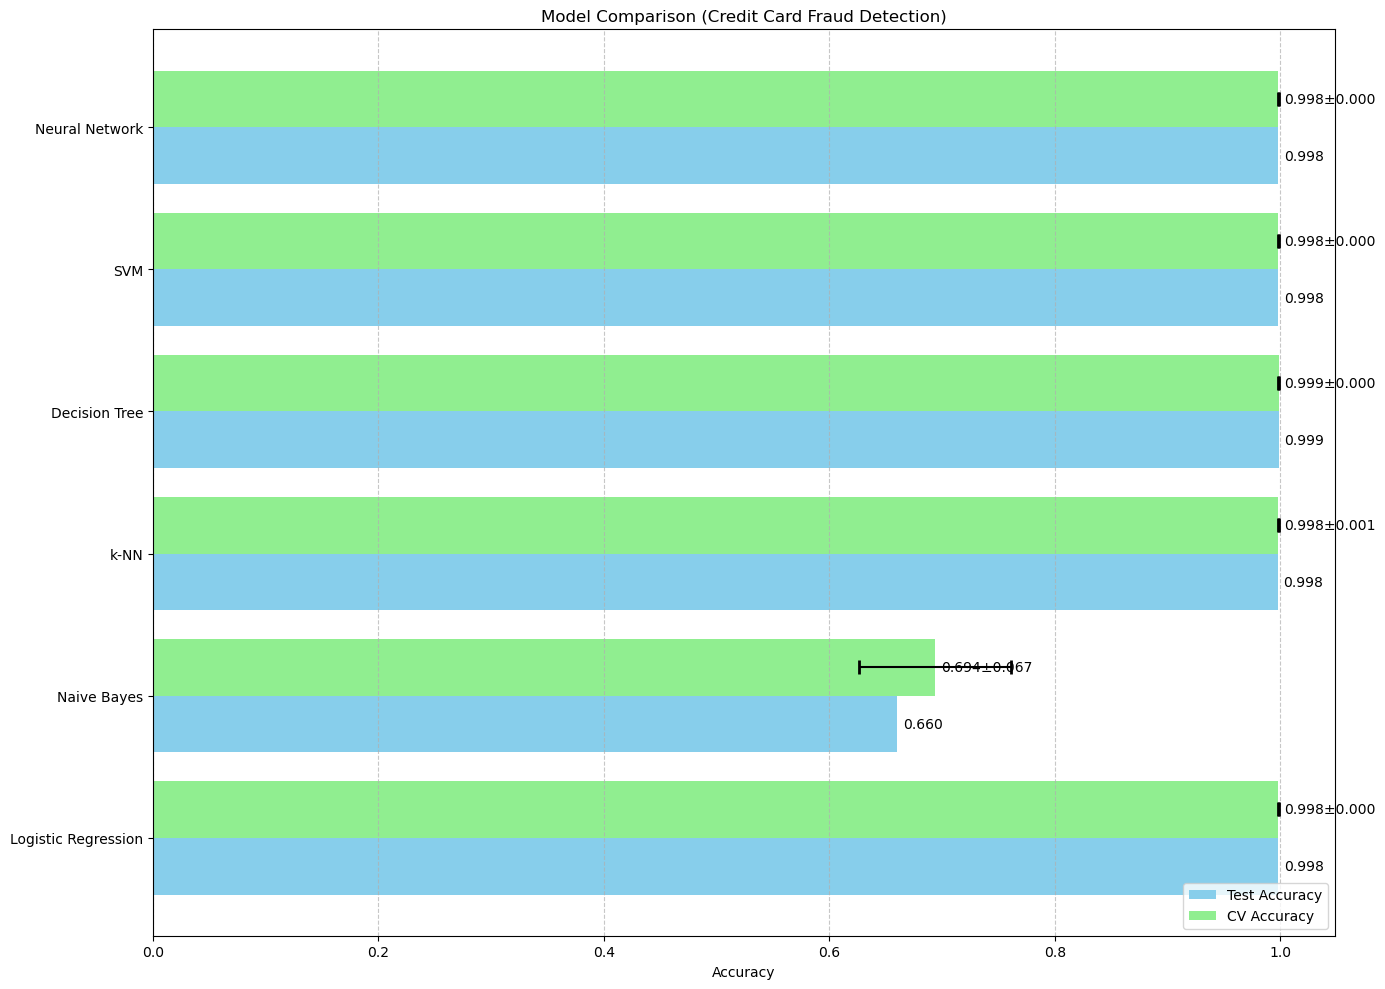

In [105]:
# We Plot results showing Model comparsions
model_names = list(results.keys())
test_accuracies = [results[name]['test_accuracy'] for name in model_names]
cv_accuracies = [results[name]['cv_mean'] for name in model_names]
cv_errors = [results[name]['cv_std'] for name in model_names]

plt.figure(figsize=(14, 10))
x_pos = np.arange(len(model_names))

plt.barh(x_pos - 0.2, test_accuracies, height=0.4, color='skyblue', label='Test Accuracy')
plt.barh(x_pos + 0.2, cv_accuracies, height=0.4, color='lightgreen', label='CV Accuracy')
plt.errorbar(cv_accuracies, x_pos + 0.2, xerr=cv_errors, 
             fmt='none', ecolor='black', capsize=5, capthick=2)

for i, (test_acc, cv_acc) in enumerate(zip(test_accuracies, cv_accuracies)):
    plt.text(test_acc + 0.005, i - 0.2, f"{test_acc:.3f}", va='center')
    plt.text(cv_acc + 0.005, i + 0.2, f"{cv_acc:.3f}±{cv_errors[i]:.3f}", va='center')

plt.yticks(x_pos, model_names)
plt.xlabel("Accuracy")
plt.title("Model Comparison (Credit Card Fraud Detection)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### Conclusion:
In summary, our top-performing models achieved over 99% accuracy, demonstrating strong potential for reliable fraud detection. Such performance can greatly enhance digital transaction security by quickly and accurately flagging suspicious activity—benefiting both businesses and consumers. These results align well with the original goals of our project.